# Cpp Implementaion handler

This notebook is used to load the directory and the .dcm inmages into an array with depth of slices to get a 3D volume array.

The we load the processed csv from the cpp implementation.

And we plot the output comparing to the pywaveltes result.

## Imports

In [1]:
# Usual imports
import matplotlib.pyplot as plt
import numpy as np
import os

# Importing the OpenCV library for image processing
import csv

# Importing the pydicom library for reading dicom files
import pydicom

## Saving directory to CSV

In [2]:
def get_dcm_files(directory):
    # Get all files in the directory
    files = os.listdir(directory)
    # Filter out only .dcm files
    dcm_files = [file for file in files if file.endswith('.dcm')]
    # Sort the files to ensure they are in order
    dcm_files.sort()
    # Get their full paths
    dcm_files = [os.path.join(directory, file) for file in dcm_files]
    return dcm_files

In [3]:
def load_dicom_files(dicom_files):
    slices = [pydicom.dcmread(file).pixel_array for file in dicom_files]
    return np.stack(slices, axis=-1)

In [4]:

def save_volume_to_csv(volume, csv_file):
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the shape of the volume as the first row in the order depth, rows, cols
        writer.writerow([volume.shape[2], volume.shape[0], volume.shape[1]])
        # Flatten the volume and write it to the CSV file in depth, rows, cols order
        for d in range(volume.shape[2]):
            for r in range(volume.shape[0]):
                writer.writerow(volume[r, :, d])

In [5]:
# Path to the directory containing the DICOM files
dicom_dir = '/home/grahampelle/cce3015/assignment-1/CHAOS-Test-Sets/CT/3/DICOM_anon/'

# List of DICOM files to read
dicom_files = get_dcm_files(dicom_dir)

# Load the DICOM files into a 3D volume
volume = load_dicom_files(dicom_files)

# Save the volume to a CSV file
csv_file = 'volume.csv'
save_volume_to_csv(volume, csv_file)

## Loading Cpp processed CSV

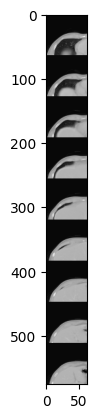

In [19]:
import csv
import numpy as np

# CSV file to load
csv_file = 'output.csv'

# Load the values from line 3 till 578 into a numpy array
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    
    # Skip the first two lines
    for _ in range(2):
        next(reader)
    
    # Read the rest of the lines till line 578
    data = []
    for _ in range(576):  # 578 - 2 skipped lines
        line = next(reader)[0].split(' ')
        # Filter out any empty strings
        filtered_line = [value for value in line if value]
        data.append(filtered_line)
    
data = np.array(data, dtype=np.float32)

# Plot the data
plt.imshow(data, cmap='gray')
plt.show()
